In [1]:
# load required libraries
options(stringsAsFactors = F)
suppressPackageStartupMessages({
library(Seurat)
library(harmony)
library(ggplot2)
library(pheatmap)
library(ggpubr)
library(dplyr)
library(Matrix)
library(Hmisc)
library(RColorBrewer)
library(ggrepel)
library(reshape2)
library(ggpubr)
library(gtools)
})
set.seed(123)

In [2]:
# load samples with TE
samples <- list.files('./matrix/', pattern = "TE")
samples

[1] "Aorta-4wk-658_TE.csv" "Aorta-5wk-555_TE.csv" "Aorta-5wk-575_TE.csv"

In [3]:
# create seurat object list
sample_list <- lapply(samples, function(sample){
    count_matrix <- read.csv(paste("./matrix", sample, sep = "/"), row.names = 1, check.names = F)
    sample <- CreateSeuratObject(count_matrix, project = unlist(strsplit(sample, split = "_"))[1])
})
sample_list

[[1]]
An object of class Seurat 
1197 features across 10000 samples within 1 assay 
Active assay: RNA (1197 features, 0 variable features)

[[2]]
An object of class Seurat 
1197 features across 4862 samples within 1 assay 
Active assay: RNA (1197 features, 0 variable features)

[[3]]
An object of class Seurat 
1197 features across 5468 samples within 1 assay 
Active assay: RNA (1197 features, 0 variable features)


In [4]:
# merge samples
sample_TE <- merge(sample_list[[1]], sample_list[2:3])
sample_TE
#saveRDS(sample_TE, "sample_human_TE_raw.rds")

Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


An object of class Seurat 
1197 features across 20330 samples within 1 assay 
Active assay: RNA (1197 features, 0 variable features)

In [5]:
# extract the annotated EHT cells
sample_gene <- readRDS("../1_EHT_RNA_Preprocessing/sample_human_agm_annotated.rds")
sample_gene <- subset(sample_gene, cells = intersect(colnames(sample_TE), colnames(sample_gene)))
sample_TE <- subset(sample_TE, cells = intersect(colnames(sample_TE), colnames(sample_gene)))
sample_gene
sample_TE

An object of class Seurat 
36601 features across 11470 samples within 1 assay 
Active assay: RNA (36601 features, 2000 variable features)
 4 dimensional reductions calculated: pca, harmony, tsne, umap

An object of class Seurat 
1197 features across 11470 samples within 1 assay 
Active assay: RNA (1197 features, 0 variable features)

In [6]:
# integrate the EHT and TE sample
count_matrix_all <- rbind(sample_gene@assays$RNA@counts, sample_TE@assays$RNA@counts)
sample <- CreateSeuratObject(count_matrix_all, meta.data = sample_gene@meta.data)
sample

An object of class Seurat 
37798 features across 11470 samples within 1 assay 
Active assay: RNA (37798 features, 0 variable features)

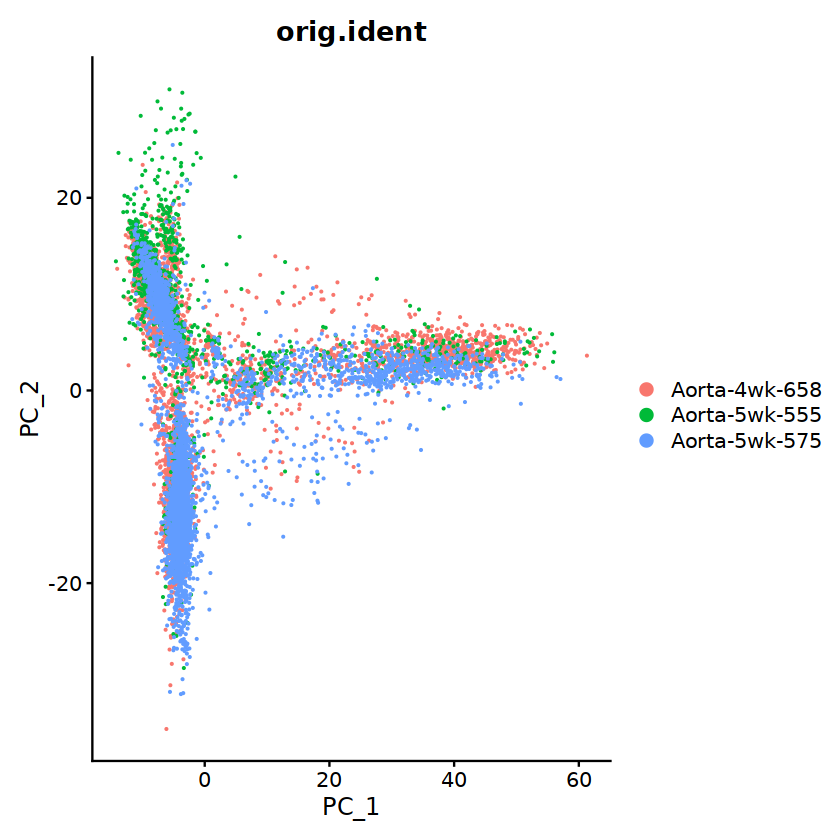

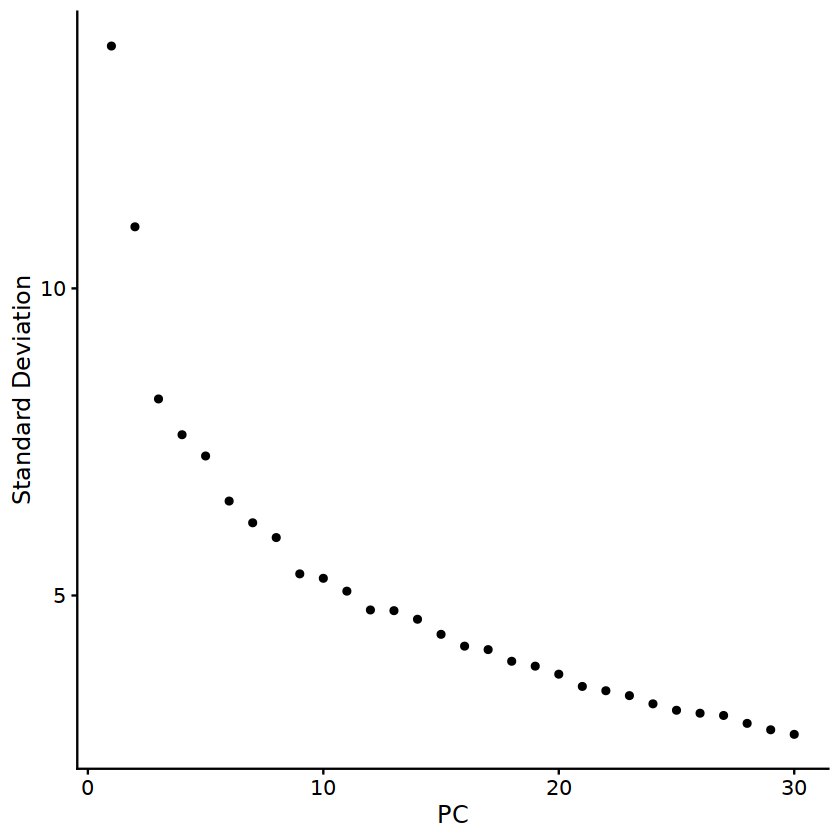

In [7]:
# normalization and pca
sample <- SCTransform(sample, return.only.var.genes = F, method = "glmGamPoi", do.scale = T, verbose = FALSE)
sample <- RunPCA(sample, verbose = FALSE)
DimPlot(sample, reduction = "pca", pt.size = 0.1, group.by = "orig.ident")
ElbowPlot(sample, ndims = 30)

In [8]:
# dimension reduction
pca_dims <- 1:25
sample <- RunTSNE(sample, dims = pca_dims, verbose = FALSE)
sample <- RunUMAP(sample, dims = pca_dims, verbose = FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


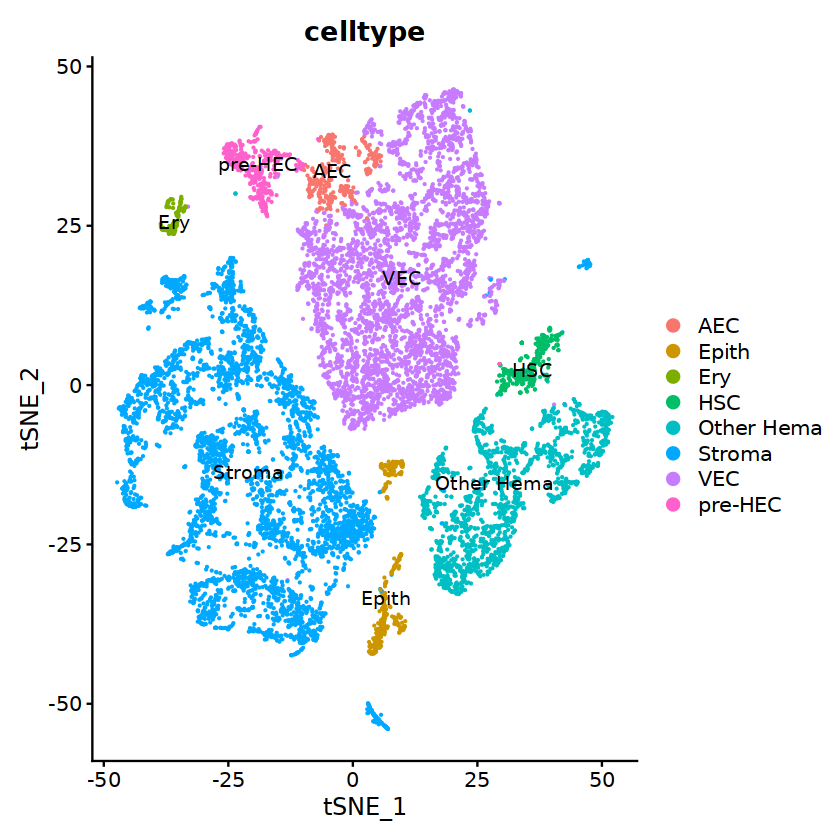

In [9]:
# transfer the cell embeddings
sample@reductions$tsne@cell.embeddings <- sample_gene@reductions$tsne@cell.embeddings
sample@reductions$umap@cell.embeddings <- sample_gene@reductions$umap@cell.embeddings
sample@reductions$umap@cell.embeddings[, 1] <- -sample@reductions$umap@cell.embeddings[, 1]
sample$celltype <- as.character(sample$celltype)
sample$celltype[sample@meta.data$seurat_clusters == 9] <- "pre-HEC"
sample$celltype[sample@meta.data$seurat_clusters == 10] <- "AEC"
sample$celltype[sample@meta.data$seurat_clusters %in% c(0,1,17)] <- "VEC"
DimPlot(sample, label=TRUE, reduction = "tsne", group.by = "celltype")

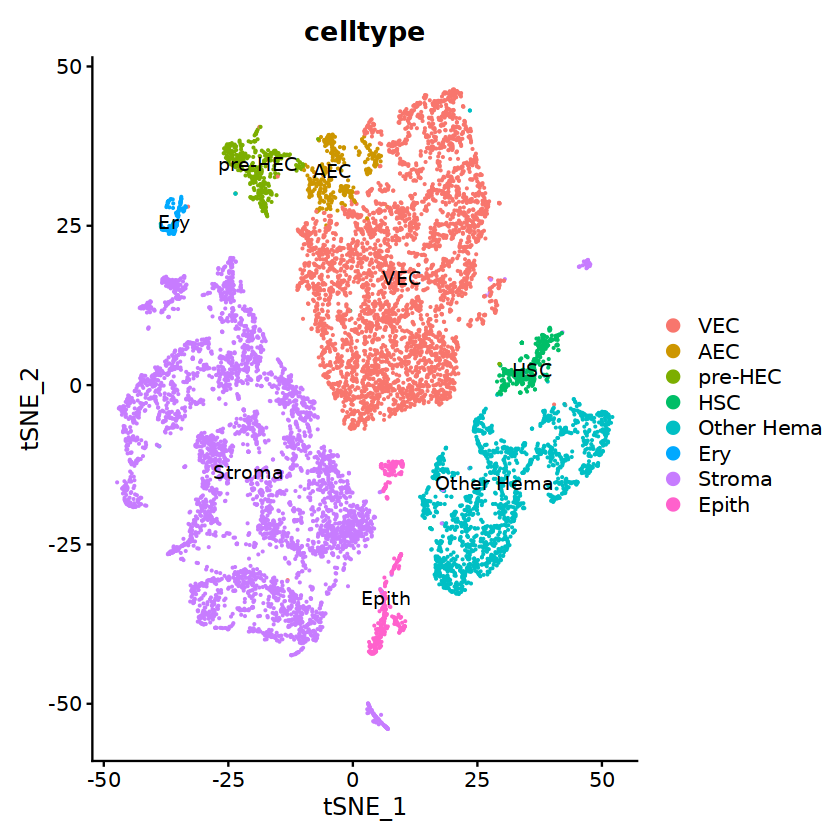

In [10]:
# plot umap
sample$celltype <- factor(sample$celltype, levels = c("VEC","AEC","pre-HEC","HSC","Other Hema", "Ery", "Stroma", "Epith"))
DimPlot(sample, label=TRUE, reduction = "tsne", group.by = "celltype", pt.size = 0.1)
ggsave("figure/umap_by_cluster_agm_human.pdf", width = 6, height = 5)

In [11]:
# identify celltype marker TE
TE_genes <- rownames(sample_TE)
Idents(sample) <- sample$celltype
celltype_marker_TE_AGM <- FindAllMarkers(sample, assay = "RNA", test.use = "MAST", only.pos = TRUE, verbose = FALSE, features = TE_genes)
celltype_marker_TE_AGM <- celltype_marker_TE_AGM[order(celltype_marker_TE_AGM$avg_log2FC, celltype_marker_TE_AGM$p_val_adj, decreasing = T), ]
sample@misc$celltype_marker_TE_AGM <- celltype_marker_TE_AGM
write.csv(celltype_marker_TE_AGM, "meta/celltype_marker_TE_AGM_human.csv")


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!


Done!

Combining coefficients and standard errors

Calcul

In [12]:
# filter markers for each cell type
marker_TE <- subset(celltype_marker_TE_AGM, avg_log2FC >= 0.25 & p_val_adj <= 0.05)
marker_TE <- marker_TE[order(marker_TE$avg_log2FC, decreasing = T), ]

marker_TE_hema <- marker_TE[marker_TE$cluster == "Other Hema", "gene"]
marker_TE_hsc <- marker_TE[marker_TE$cluster == "HSC", "gene"]
marker_TE_vec <- marker_TE[marker_TE$cluster == "VEC", "gene"]
marker_TE_aec <- marker_TE[marker_TE$cluster == "AEC", "gene"]
marker_TE_prehec <- marker_TE[marker_TE$cluster == "pre-HEC", "gene"]
marker_TE_ery <- marker_TE[marker_TE$cluster == "Ery", "gene"]
marker_TE_stroma <- marker_TE[marker_TE$cluster == "Stroma", "gene"]
marker_TE_epith <- marker_TE[marker_TE$cluster == "Epith", "gene"]

In [13]:
# down sampling VEC, Hema and Stroma
set.seed(123)
cells_vec <- sample(colnames(subset(sample, idents = "VEC")), 500)
cells_aec<- sample(colnames(subset(sample, idents = "AEC")))
cells_prehec <- sample(colnames(subset(sample, idents = "pre-HEC")))
cells_hsc <- sample(colnames(subset(sample, idents = "HSC")))
cells_hema <- sample(colnames(subset(sample, idents = "Other Hema")), 500)
cells_ery <- sample(colnames(subset(sample, idents = "Ery")))
cells_stroma <- sample(colnames(subset(sample, idents = "Stroma")), 500)
cells_epith <- sample(colnames(subset(sample, idents = "Epith")))
sample_selected <- subset(sample, cells = c(cells_vec, cells_aec, cells_prehec, cells_hsc, cells_hema, cells_ery, cells_stroma, cells_epith))

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


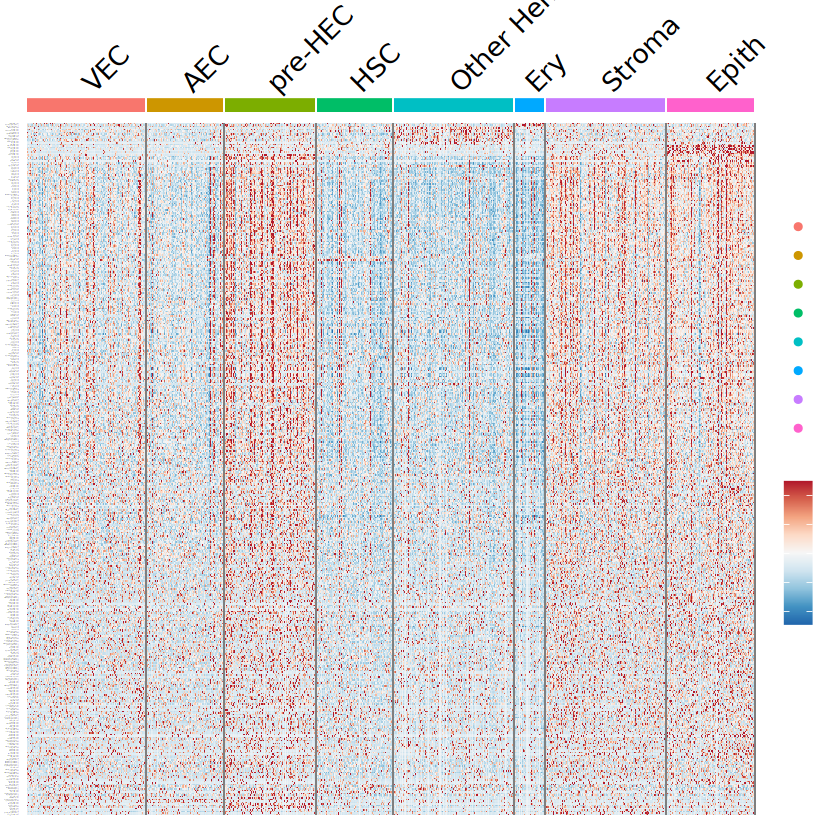

In [14]:
# draw heatmap
sample$celltype <- factor(sample$celltype, levels = c("VEC","AEC","pre-HEC","HSC","Other Hema", "Ery", "Stroma", "Epith"))
mapal <- rev(colorRampPalette(RColorBrewer::brewer.pal(9, "RdBu"))(100))
DoHeatmap(sample_selected, features = unique(c(marker_TE_ery, marker_TE_hema, marker_TE_epith, marker_TE_hsc, marker_TE_vec, marker_TE_aec, marker_TE_prehec, marker_TE_stroma)), group.by = "celltype") + theme(text = element_text(size = 0, color = "white")) + scale_fill_gradientn(colours = mapal)
ggsave("figure/heatmap_sample_TE_AGM_human.pdf", width = 8, height = 10)

In [15]:
# score the TE sets
te_list <- list(TEs = unique(marker_TE$gene))
sample_score <- sample
sample_score <- AddModuleScore(sample_score, features = te_list, assay = "SCT")
colnames(sample_score@meta.data)[10] <- names(te_list)

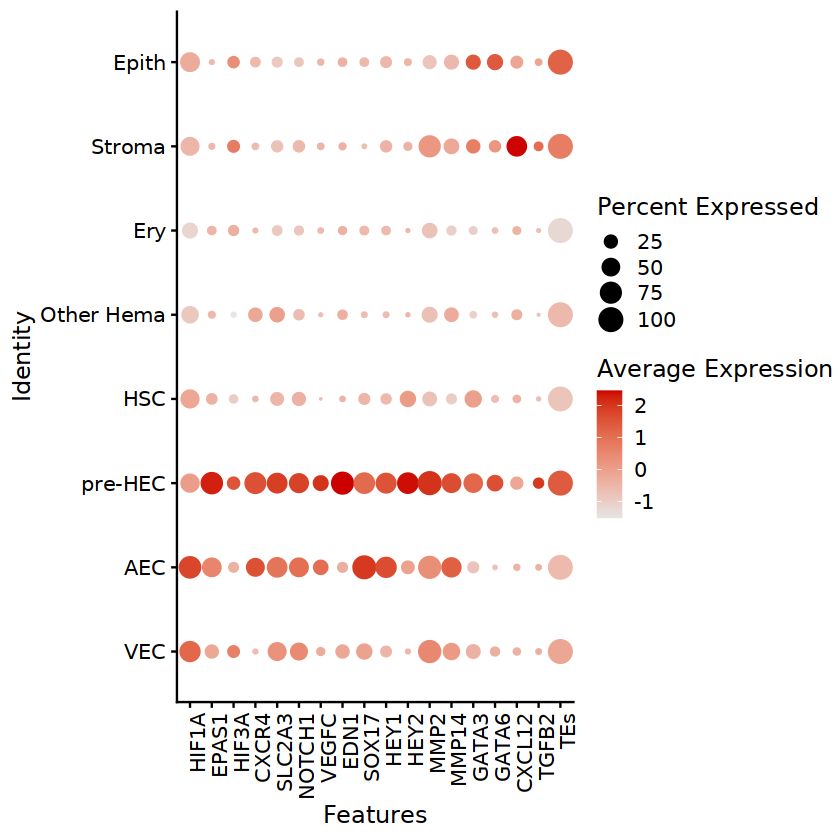

In [16]:
# plot selected hypoxia related genes
hypoxia_response_gene_selected <- c("HIF1A", "EPAS1", "HIF3A", "CXCR4","SLC2A3", "NOTCH1","VEGFC","EDN1","SOX17","HEY1","HEY2","MMP2","MMP14","GATA3","GATA6","CXCL12","TGFB2","TEs")
DotPlot(sample_score, features = hypoxia_response_gene_selected, cols = c("grey90","red3"), group.by = "celltype", scale.by = "size") + theme(axis.text.x = element_text(angle = 90, hjust = 1))
ggsave("figure/hypoxia_response_genes_selected_agm_human.pdf", width = 8, height = 3)

In [17]:
# plot marker genes
markers <- c("HIF1A","EPAS1","HIF3A","CXCL12","CXCR4","NOTCH1","VEGFC","SOX17","HEY1","HEY2","GATA3","GATA6")
for(gene in markers){
    FeaturePlot(sample, features=gene, cols=c("grey90","red3"), reduction="tsne", keep.scale = "all", min.cutoff = 0)
    ggsave(paste("figure/AGM_Hypoxia_", gene, ".pdf", sep = ""), width = 5.5, height = 5)
}

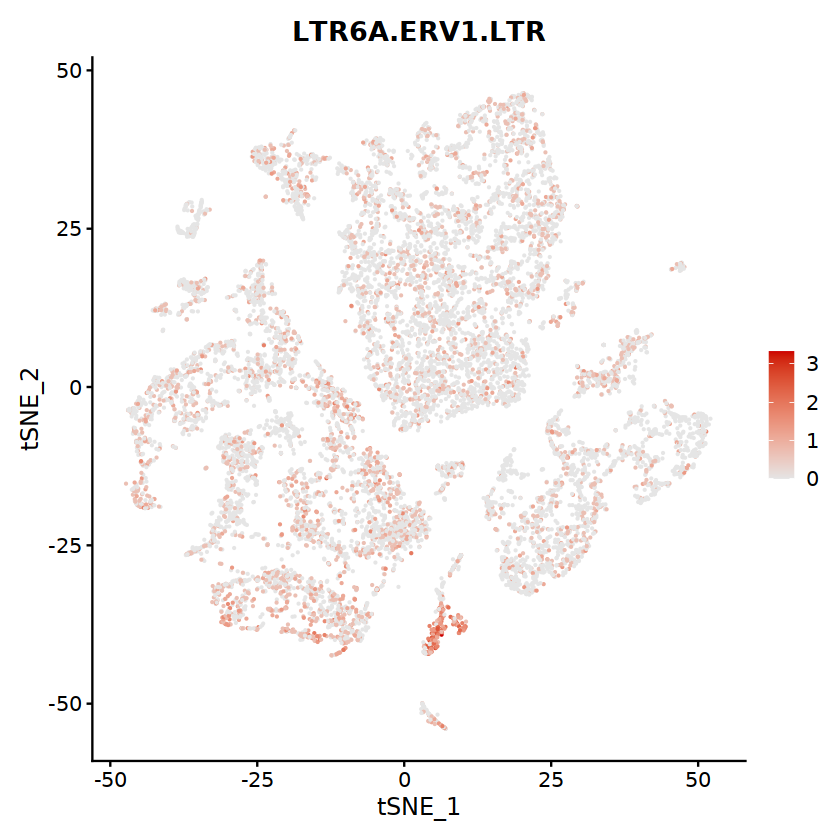

In [18]:
# marker TE for epith
gene <- "LTR6A.ERV1.LTR"
FeaturePlot(sample, features=gene, cols=c("grey90","red3"), reduction="tsne", keep.scale = "all", min.cutoff = 0)
ggsave(paste("figure/AGM_TE_", gene, ".pdf", sep = ""), width = 5.5, height = 5)

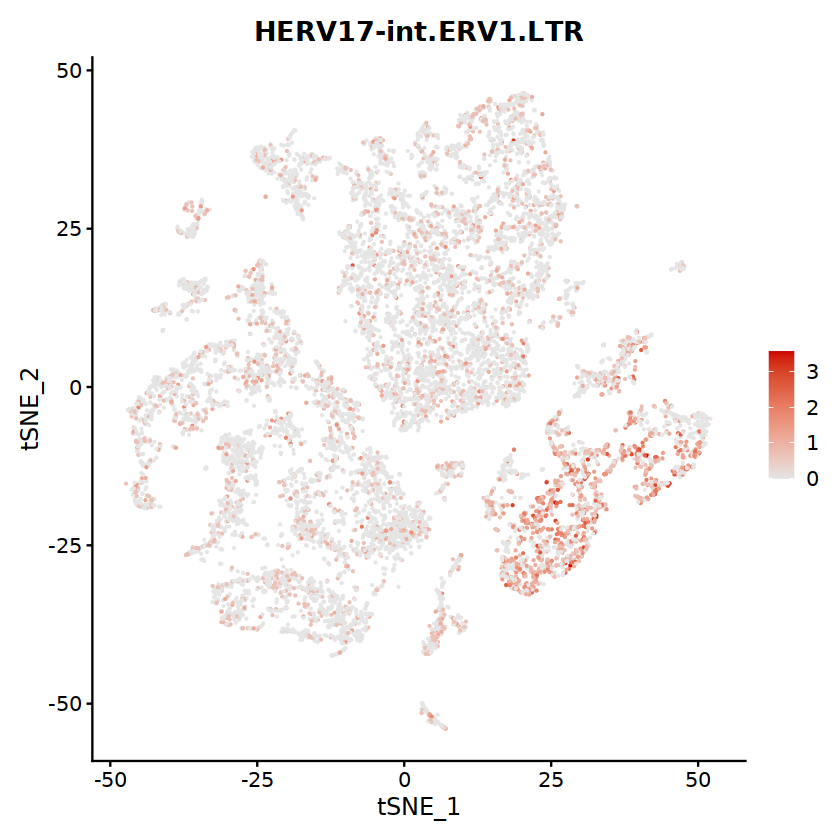

In [19]:
# marker TE for other hema
gene <- "HERV17-int.ERV1.LTR"
FeaturePlot(sample, features=gene, cols=c("grey90","red3"), reduction="tsne", keep.scale = "all", min.cutoff = 0)
ggsave(paste("figure/AGM_TE_", gene, ".pdf", sep = ""), width = 5.5, height = 5)

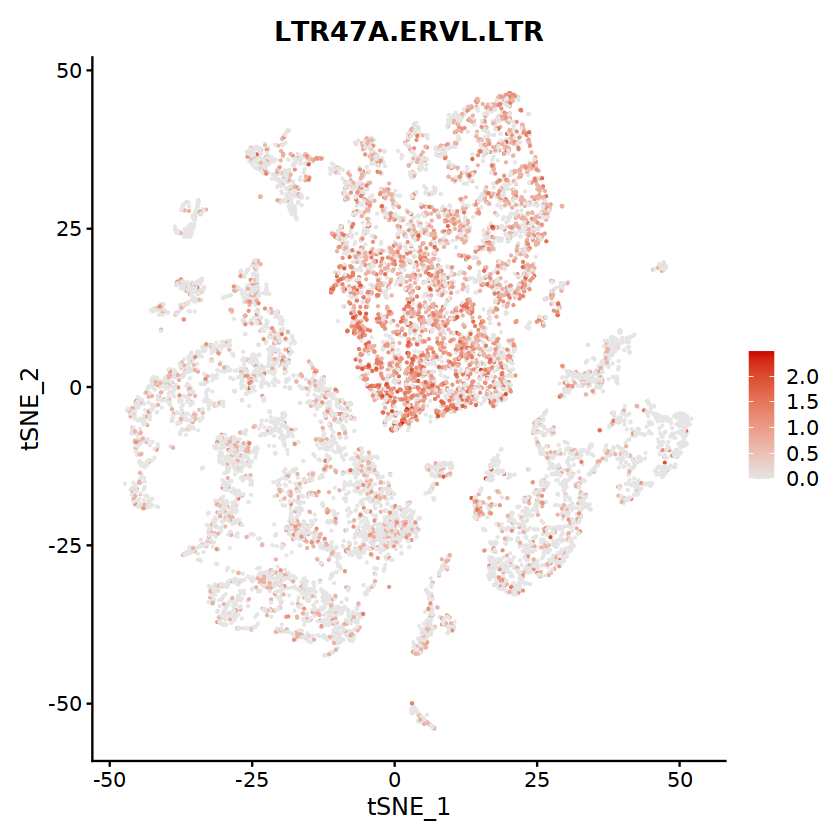

In [20]:
# marker TE for vec
gene <- "LTR47A.ERVL.LTR"
FeaturePlot(sample, features=gene, cols=c("grey90","red3"), reduction="tsne", keep.scale = "all", min.cutoff = 0)
ggsave(paste("figure/AGM_TE_", gene, ".pdf", sep = ""), width = 5.5, height = 5)

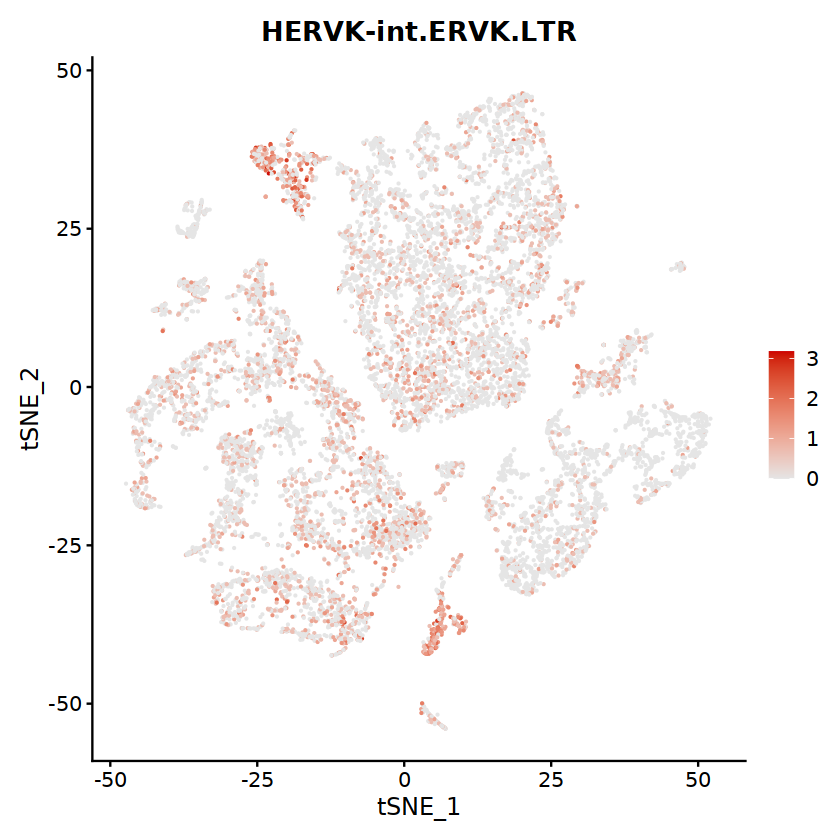

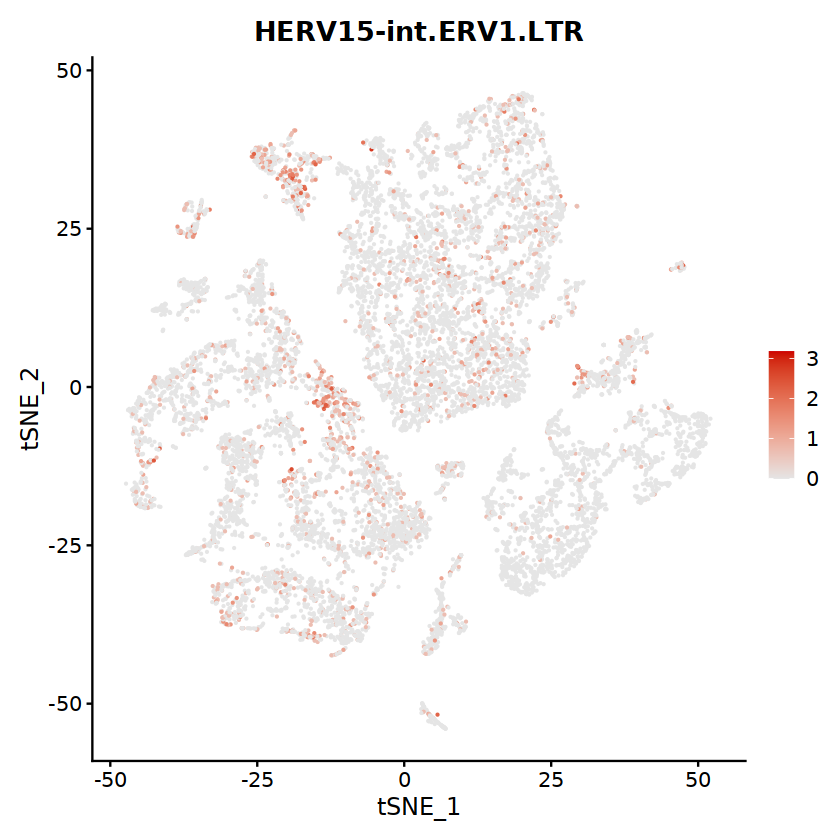

In [21]:
# marker TE for pre-HEC
gene <- "HERVK-int.ERVK.LTR"
FeaturePlot(sample, features=gene, cols=c("grey90","red3"), reduction="tsne", keep.scale = "all", min.cutoff = 0)
ggsave(paste("figure/AGM_TE_", gene, ".pdf", sep = ""), width = 5.5, height = 5)

gene <- "HERV15-int.ERV1.LTR"
FeaturePlot(sample, features=gene, cols=c("grey90","red3"), reduction="tsne", keep.scale = "all", min.cutoff = 0)
ggsave(paste("figure/AGM_TE_", gene, ".pdf", sep = ""), width = 5.5, height = 5)

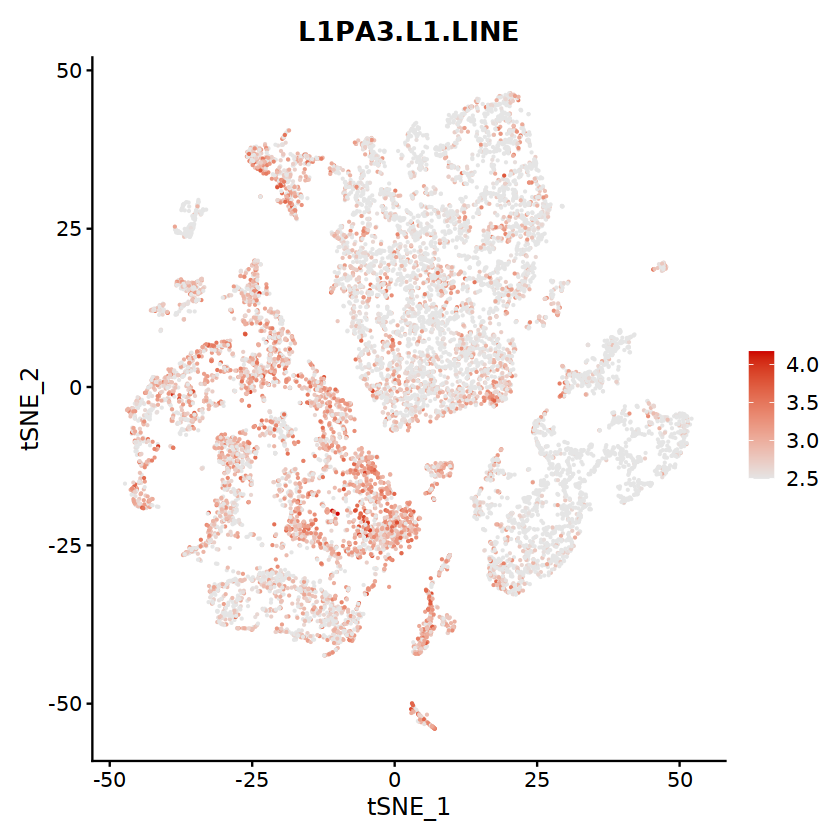

In [22]:
# marker TE for stroma
gene <- "L1PA3.L1.LINE"
FeaturePlot(sample, features=gene, cols=c("grey90","red3"), reduction="tsne", keep.scale = "all", min.cutoff = 2.5)
ggsave(paste("figure/AGM_TE_", gene, ".pdf", sep = ""), width = 5.5, height = 5)

In [25]:
# save the agm data
saveRDS(sample, file = "sample_human_TE_AGM.rds")

In [23]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS/LAPACK: /root/miniconda3/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] gtools_3.9.4       reshape2_1.4.4     ggrepel_0.9.3      RColorBrewer_1.1-3
 [5] Hmisc_5.0-1        Matrix_1.5-4       dplyr_1.1.1        ggpubr_0.6.0      
 [9] pheatmap_1.0.12    ggplot2_3.4.2      harmony_0.1.1      Rcpp_1.0.10       
[13] SeuratObject_4.1.3 Seurat_4.3.0      

loaded via a namespace (and not attached):
  [1] uuid_1.1-0                  backports_1.4.1            
  [3] systemfonts_1.0.4  